In [7]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
functR <- 'priler_project/Figure_CASTom-iGEx_paper/Functions_prediction_plots.R'
source(functR)

color_file <- 'priler_project/Figures/color_tissues.txt'
fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/'
fold_rep <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/'
pheno <- 'CAD_HARD'
train_fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/'
type_dat <- 'CAD_HARD-UKBB'
pval_FDR <- 0.05

# load results
color_tissues <- read.table(color_file, h=T, stringsAsFactors = F)
tscore <- fread(sprintf('%stscore_pval_%s_covCorr.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t', data.table = F)
pathR <- fread(sprintf('%spath_Reactome_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t', data.table = F)
pathGO <- fread(sprintf('%spath_GO_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t', data.table = F)
tissues <- unique(tscore$tissue)
train_fold <- paste0(train_fold, tissues, '/200kb/CAD_GWAS_bin5e-2/')
out_fold <- 'priler_project/Figure_CASTom-iGEx_paper/CAD_part1/'

# gene location
tscore$start_position <- NA
tscore$chrom <- NA
tscore$TSS_start <- NA
for(i in 1:length(train_fold)){
  tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold[i]), h=T,stringsAsFactors = F, data.table = F)
  tmp <- tmp[match(tscore$ensembl_gene_id[tscore$tissue == tissues[i]], tmp$ensembl_gene_id),]
  tscore$start_position[tscore$tissue == tissues[i]] <- tmp$start_position
  tscore$chrom[tscore$tissue == tissues[i]] <- tmp$chrom
  tscore$TSS_start[tscore$tissue == tissues[i]] <- tmp$TSS_start   
}

# load loci and gwas res
tscore_loci <- fread(sprintf('%sGeneTscores_CADHARD_annotated.txt', fold), h=T, stringsAsFactors = F, sep = '\t', data.table = F)
gwas_res <- fread('refData/UKBB.GWAS1KG.EXOME.CAD.SOFT.META.PublicRelease.300517.txt.gz',  h=T, stringsAsFactors = F, sep = '\t', data.table = F)
colnames(gwas_res)[colnames(gwas_res) == 'p-value_gc'] <- 'p.value_gc'
gwas_res <- gwas_res[!is.na(gwas_res$chr), ]
# correct pvalues
gwas_res$pval_corr <- p.adjust(gwas_res$p.value_gc, method = 'BH')
gwas_res$chrom <- paste0('chr', gwas_res$chr)


[1] "C"

In [8]:
#################################
### compare results with GWAS ###
#################################

ann_loci <- data.frame(loci_id = unique(tscore_loci$loci_complete), stringsAsFactors = F)
ann_loci$chr <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][1])
tmp <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][2])
ann_loci$start <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][1])
ann_loci$end <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][2])
ann_loci$best_GWAS_pval <- NA
ann_loci$best_GWAS_sign <- NA
ann_loci$best_GWAS_signBH <- NA

for(i in 1:nrow(ann_loci)){
   start_loci <- as.numeric(ann_loci$start[i])
   end_loci <- as.numeric(ann_loci$end[i])                
   id <- gwas_res$chrom == ann_loci$chr[i] & gwas_res$bp_hg19 <= end_loci & gwas_res$bp_hg19 >= start_loci
   tmp <- gwas_res[id, ]
   if(nrow(tmp)>0){
       ann_loci$best_GWAS_pval[i] <- min(tmp$p.value_gc)
       ann_loci$best_GWAS_sign[i] <- any(tmp$p.value_gc <= 5*10^-8)
       ann_loci$best_GWAS_signBH[i] <- any(tmp$pval_corr <= 0.05)     
   }
}


In [9]:
# how many loci intersect significant GWAS results (Genomewide and BH correction)
table(ann_loci$best_GWAS_sign, ann_loci$best_GWAS_signBH)
# annotate gene table:
tscore_loci$best_GWAS_signBH <- NA
tscore_loci$best_GWAS_sign <- NA
tscore_loci$best_GWAS_pval <- NA
for(i in 1:nrow(ann_loci)){
    tscore_loci$best_GWAS_signBH[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_signBH[i]
    tscore_loci$best_GWAS_sign[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_sign[i]
    tscore_loci$best_GWAS_pval[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_pval[i]
}


paste('unique new genes:', nrow(tscore_loci[!duplicated(tscore_loci$ensembl_gene_id) & !tscore_loci$best_GWAS_signBH,]))
paste('total new genes:', nrow(tscore_loci[!tscore_loci$best_GWAS_signBH,]))

       
        FALSE TRUE
  FALSE    33   26
  TRUE      0   24

[1] "unique new genes: 48"

[1] "total new genes: 92"

In [10]:
# add replication
tscore_repl <- fread(sprintf('%stscore_pval_Dx_covCorr.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
rep_df <- data.frame(CardioGram_beta = c(), CardioGram_se_beta =c(), CardioGram_z =c(),
                    CardioGram_pval =c(), CardioGram_pval_BHcorr =c(), CardioGram_Cochran_stat =c(),
                    CardioGram_Cochran_pval =c(), CardioGram_model = c(), stringsAsFactors = F)

for(i in 1:nrow(tscore_loci)){
    
    tmp <- tscore_repl[tscore_repl$ensembl_gene_id == tscore_loci$ensembl_gene_id[i] & tscore_repl$tissue == tscore_loci$tissue[i],]
    new <- data.frame(CardioGram_beta = tmp$Dx_beta, CardioGram_se_beta =tmp$Dx_se_beta, CardioGram_z =tmp$Dx_z,
                    CardioGram_pval =tmp$Dx_pval, CardioGram_pval_BHcorr =tmp$Dx_pval_BHcorr, 
                      CardioGram_Cochran_stat =tmp$Dx_Cochran_stat,
                    CardioGram_Cochran_pval =tmp$Dx_Cochran_pval, CardioGram_model = tmp$Dx_model,  stringsAsFactors = F)
    rep_df <- rbind(rep_df,new)
}
tscore_complete <- cbind(tscore_loci, rep_df)
tscore_complete$replicated <- NA
tscore_complete$replicated <- sign(tscore_complete$CAD_HARD_z_t * tscore_complete$CardioGram_z)==1
table(tscore_complete$replicated, !tscore_complete$best_GWAS_signBH)
# save
write.table(tscore_complete, file = sprintf('%sGeneTscores_CADHARD_annotated_intGWAS_withReplication.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

       
        FALSE TRUE
  FALSE    37   33
  TRUE    254   59

In [11]:
############################################
### annotate pathway significant results ###
############################################

common_i <- intersect(colnames(pathR), colnames(pathGO))
tmp1 <- pathR[, common_i]
tmp2 <- pathGO[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tot_path <- rbind(tmp1, tmp2)
# consider only significant ones:
tot_path <- tot_path[, !colnames(tot_path) %in% 'CAD_HARD_BHcorr_overall']
sign_path <- tot_path[tot_path[,15]<= 0.05,]

# add a column that indicates whether there is any gene from new loci
sign_path$gene_from_newloci <- NA

for(i in 1:nrow(sign_path)){
    
    id <- sapply(tscore_complete$external_gene_name, function(x) grepl(x, sign_path$genes_path[i])) & sign_path$tissue[i] == tscore_complete$tissue
    id <- id & !tscore_complete$best_GWAS_signBH
    if(any(id)){
        sign_path$gene_from_newloci[i] <- paste0(unique(tscore_complete$external_gene_name[id]), collapse = ',')
    }
}
paste('pathway from new loci:', sum(!is.na(sign_path$gene_from_newloci)), 'out of', nrow(sign_path))

# add replication
pathR_repl <- fread(sprintf('%spath_Reactome_pval_Dx_covCorr_filt.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
pathGO_repl <- fread(sprintf('%spath_GO_pval_Dx_covCorr_filt.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
common_i <- intersect(colnames(pathR_repl), colnames(pathGO_repl))
tmp1 <- pathR_repl[, common_i]
tmp2 <- pathGO_repl[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tot_path_repl <- rbind(tmp1, tmp2)

rep_df <- data.frame(CardioGram_beta = c(), CardioGram_se_beta =c(), CardioGram_z =c(),
                    CardioGram_pval =c(), CardioGram_pval_BHcorr =c(), CardioGram_Cochran_stat =c(),
                    CardioGram_Cochran_pval =c(), CardioGram_model = c(), stringsAsFactors = F)

for(i in 1:nrow(sign_path)){
    
    tmp <- tot_path_repl[tot_path_repl$path == sign_path$path[i] & tot_path_repl$tissue == sign_path$tissue[i],]
    new <- data.frame(CardioGram_beta = tmp$Dx_beta, CardioGram_se_beta =tmp$Dx_se_beta, CardioGram_z =tmp$Dx_z,
                    CardioGram_pval =tmp$Dx_pval, CardioGram_pval_BHcorr =tmp$Dx_pval_BHcorr, 
                      CardioGram_Cochran_stat =tmp$Dx_Cochran_stat,
                    CardioGram_Cochran_pval =tmp$Dx_Cochran_pval, CardioGram_model = tmp$Dx_model,  stringsAsFactors = F)
    rep_df <- rbind(rep_df,new)
}
path_complete <- cbind(sign_path, rep_df)
path_complete$replicated <- NA
path_complete$replicated <- sign(path_complete$CAD_HARD_z_t * path_complete$CardioGram_z)==1
# replicated pathways with genes from new loci
table(path_complete$replicated, !is.na(path_complete$gene_from_newloci))
# save
write.table(path_complete, file = sprintf('%sPathScores_CADHARD_annNewLoci_withReplication.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

[1] "pathway from new loci: 48 out of 494"

       
        FALSE TRUE
  FALSE    67    3
  TRUE    379   45


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                                   278                                     74 
pathway P < genes P & genes FDR > 0.05 
                                   142 


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                             0.5627530                              0.1497976 
pathway P < genes P & genes FDR > 0.05 
                             0.2874494 

[1] 494

,type_path,tissue,path,ngenes_tscore,log10p,zstat,impr,no_sign_genes,mean_gene_log10p,max_gene_log10p,min_gene_log10p,mean_gene_z,max_gene_z,min_gene_z,class,class_effect,tissue_tot
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<fct>
470,GO,Whole_Blood,spermatid nucleus differentiation,2,5.543013,4.680333,1,TRUE,3.0297317,3.234029,2.825434095,3.3074584,3.439214,3.1757026,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
108,Reactome,Heart_Atrial_Appendage,G1/S DNA Damage Checkpoints,5,5.356043,-4.591291,1,TRUE,1.4568645,2.063804,0.537613164,-2.0537153,-1.058138,-2.6262285,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
32,Reactome,Artery_Aorta,Death Receptor Signalling,25,4.980636,4.407523,1,TRUE,0.6432425,2.375995,0.003153594,0.8826429,2.862185,-0.7321680,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
182,GO,Adipose_Visceral_Omentum,polysaccharide binding,2,4.959186,-4.396810,1,TRUE,2.7216587,2.766282,2.677035317,-3.1055874,-3.075201,-3.1359739,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
75,Reactome,Colon_Sigmoid,Interleukin-6 signaling,2,4.884482,-4.359312,1,TRUE,2.7025205,3.169862,2.235178899,-3.0784213,-2.757831,-3.3990120,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
212,GO,Adrenal_Gland,signal transduction in response to DNA damage,2,4.838209,-4.335936,1,TRUE,2.6752313,2.939312,2.411151076,-3.0693750,-2.887744,-3.2510058,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
158,GO,Adipose_Subcutaneous,peptidyl-tyrosine phosphorylation,7,4.761725,4.297044,1,TRUE,1.0577384,1.992840,0.130259490,1.6228186,2.570124,0.3307048,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
179,GO,Adipose_Visceral_Omentum,ectoderm development,2,4.709182,-4.270138,1,TRUE,2.6122800,2.963917,2.260643361,-3.0220111,-2.776943,-3.2670789,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues
388,GO,Heart_Atrial_Appendage,proteasome-mediated ubiquitin-dependent protein catabolic process,3,4.696522,4.263632,1,TRUE,1.9632996,2.720587,0.814344836,2.4598744,3.104985,1.4278331,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues


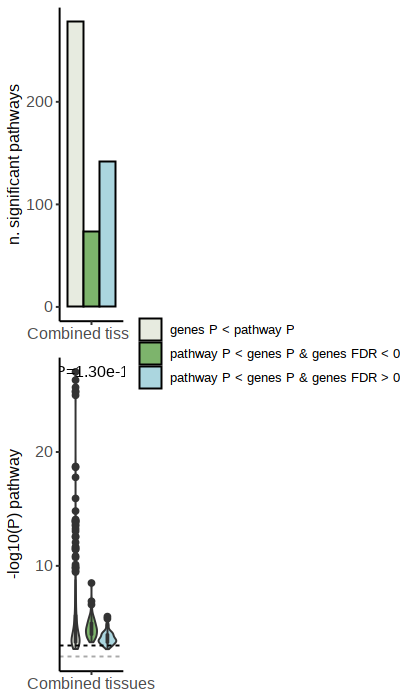

In [12]:
#######################################################################
### number of significant pathways that have better sign than genes ###
#######################################################################
# all tissues combined

options(repr.plot.width = 4, repr.plot.height = 7, repr.plot.res = 100)
pl_npath <- plot_classPath(path_sign = path_complete, gene_tot = tscore, id_pval = 13, id_pval_gene = 8, pval_FDR = pval_FDR, 
               fold = out_fold, pheno = pheno, height_pl = 5, width_pl = 5)

pl_npath$pl
table(pl_npath$df$class)
table(pl_npath$df$class)/nrow(pl_npath$df)
nrow(pl_npath$df)
#summary(pl_npath$df$log10p[pl_npath$df$class == 'genes P < pathway P'])
#summary(pl_npath$df$log10p[pl_npath$df$class == 'pathway P < genes P\ngenes FDR < 0.05'])
a = pl_npath$df[order(pl_npath$df$log10p, decreasing = T),]
a[a$class == 'pathway P < genes P & genes FDR > 0.05',][1:10,]

path_complete_ann <- path_complete
path_complete_ann$class_pathway <- NA
pl_npath$df$class <- as.character(pl_npath$df$class)
for(i in 1:nrow(path_complete_ann)){
  id <- pl_npath$df$path == path_complete_ann$path[i] & pl_npath$df$tissue == path_complete_ann$tissue[i] & pl_npath$df$type_path == path_complete_ann$type_path[i] 
  path_complete_ann$class_pathway[i] <- pl_npath$df$class[id]
}
# save
write.table(path_complete_ann, file = sprintf('%sPathScores_CADHARD_annNewLoci_withReplication_annClass.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)


                          
                           genes P < pathway P
  Adipose_Subcutaneous                      18
  Adipose_Visceral_Omentum                   4
  Adrenal_Gland                             28
  Artery_Aorta                              64
  Artery_Coronary                            9
  Colon_Sigmoid                             44
  Colon_Transverse                          16
  Heart_Atrial_Appendage                    22
  Heart_Left_Ventricle                       7
  Liver                                     41
  Whole_Blood                               25
                          
                           pathway P < genes P & genes FDR < 0.05
  Adipose_Subcutaneous                                          1
  Adipose_Visceral_Omentum                                      2
  Adrenal_Gland                                                12
  Artery_Aorta                                                 12
  Artery_Coronary                                   

                          
                           genes P < pathway P
  Adipose_Subcutaneous              0.56250000
  Adipose_Visceral_Omentum          0.28571429
  Adrenal_Gland                     0.51851852
  Artery_Aorta                      0.65306122
  Artery_Coronary                   0.33333333
  Colon_Sigmoid                     0.62857143
  Colon_Transverse                  0.51612903
  Heart_Atrial_Appendage            0.42307692
  Heart_Left_Ventricle              0.38888889
  Liver                             0.71929825
  Whole_Blood                       0.60975610
                          
                           pathway P < genes P & genes FDR < 0.05
  Adipose_Subcutaneous                                 0.03125000
  Adipose_Visceral_Omentum                             0.14285714
  Adrenal_Gland                                        0.22222222
  Artery_Aorta                                         0.12244898
  Artery_Coronary                                   

                          
                               FALSE      TRUE
  Adipose_Subcutaneous     0.4375000 0.5625000
  Adipose_Visceral_Omentum 0.7142857 0.2857143
  Adrenal_Gland            0.4814815 0.5185185
  Artery_Aorta             0.3469388 0.6530612
  Artery_Coronary          0.6666667 0.3333333
  Colon_Sigmoid            0.3714286 0.6285714
  Colon_Transverse         0.4838710 0.5161290
  Heart_Atrial_Appendage   0.5769231 0.4230769
  Heart_Left_Ventricle     0.6111111 0.3888889
  Liver                    0.2807018 0.7192982
  Whole_Blood              0.3902439 0.6097561

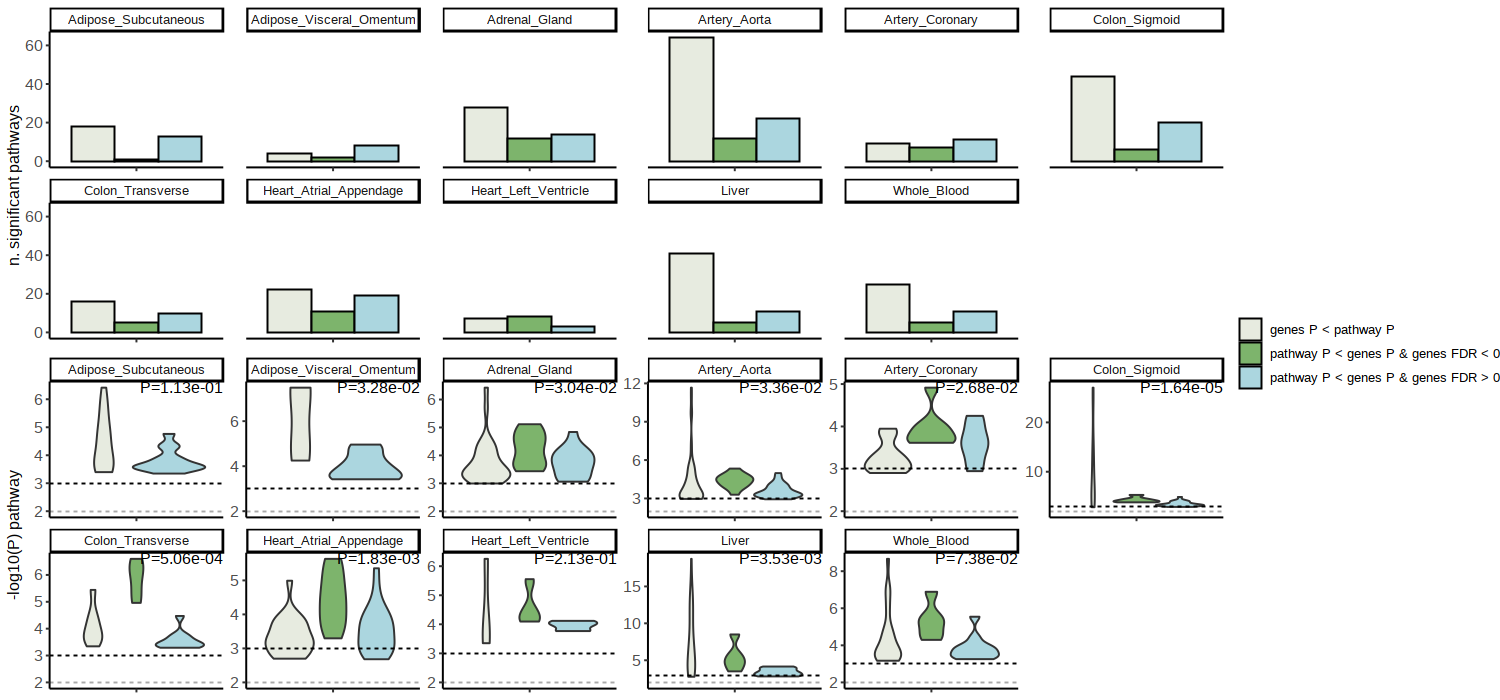

In [13]:
# tissue specific
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 100)

pl_npath <- plot_classPath(path_sign = path_complete, gene_tot = tscore, id_pval = 13, id_pval_gene = 8, pval_FDR = pval_FDR, 
               fold = paste0(out_fold, '/tissueSpec_'), pheno = pheno, tissue_type = 'specific', width_pl = 13, height_pl = 7)

pl_npath$pl
# number/percentage of pathway class per tissue
table(pl_npath$df$tissue, pl_npath$df$class)
table(pl_npath$df$tissue, pl_npath$df$class)/rowSums(table(pl_npath$df$tissue, pl_npath$df$class))
table(pl_npath$df$tissue, pl_npath$df$class == 'genes P < pathway P')/rowSums(table(pl_npath$df$tissue, pl_npath$df$class == 'genes P < pathway P'))


png 
  2

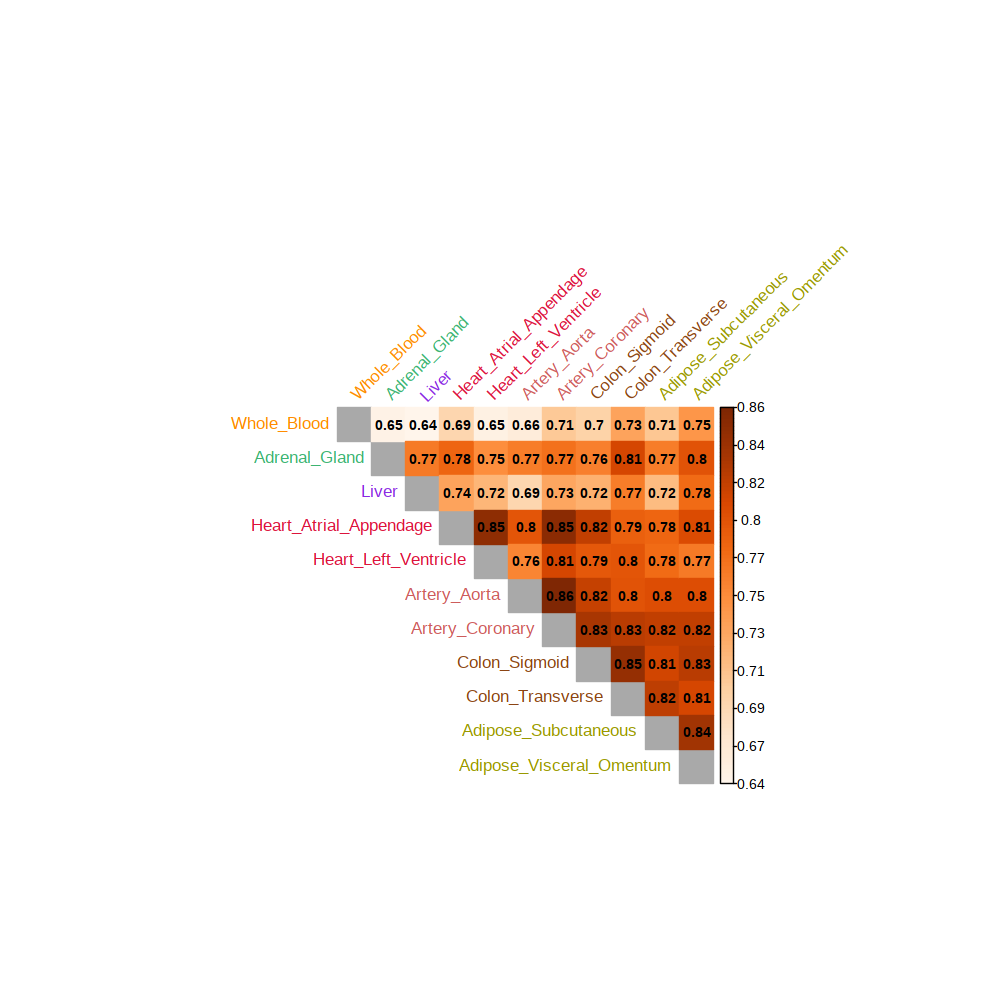

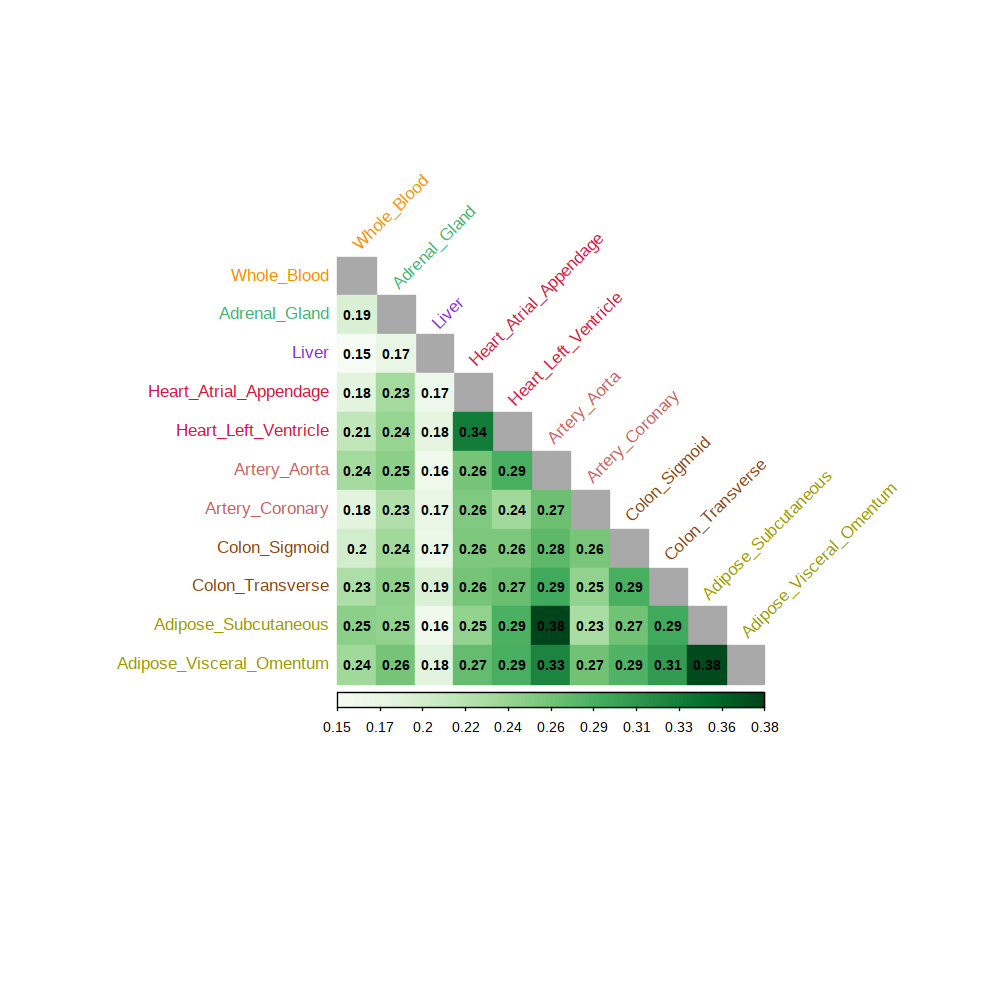

In [14]:
###########################################################
### spearman correlation and Jaccard index shared genes ###
###########################################################
# Fig. 1C
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

tscore_cor <- create_cor(tissues_name = tissues, res = tscore, id_z = 7)
# save
pl_corr(tscore_cor, type_mat = 'tscore', type_dat = type_dat, tissues_name = tissues, df_color = color_tissues, outFold = out_fold, width_pl = 10, height_pl = 7)

# print plots corr + perc
col_val <- colorRampPalette(brewer.pal(9, "Oranges"))
ord <- corrMatOrder(tscore_cor$cor, order = "hclust", hclust.method = "ward.D")
newcolours <- color_tissues$color[match(tissues, color_tissues$tissues)][ord]
diag(tscore_cor$cor) <- NA
corrplot(tscore_cor$cor, type = "upper", order = "hclust", hclust.method = "ward.D", 
        tl.col = newcolours, col = col_val(100),
        method = "color", tl.srt = 45, cl.align.text = "c", addCoef.col = "black", 
        na.label = "square", na.label.col = "darkgrey", is.corr = FALSE, 
        number.cex = 0.8)

diag(tscore_cor$perc) <- NA
col_val <- colorRampPalette(brewer.pal(9, "Greens"))(100)
corrplot(tscore_cor$perc[ord, ord], type = "lower", tl.col = newcolours, 
        col = col_val, method = "color", tl.srt = 45, 
        cl.align.text = "c", addCoef.col = "black", na.label = "square", 
        na.label.col = "darkgrey", is.corr = F, number.cex = 0.8)



[1] "tscore"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
12,All,36424,383,13408,180


[1] "tscore not MHC"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
12,All,35571,303,13216,163


[1] "path-Reactome"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
12,All,9024,143,1435,102


[1] "path-GO"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
12,All,24620,351,4982,299


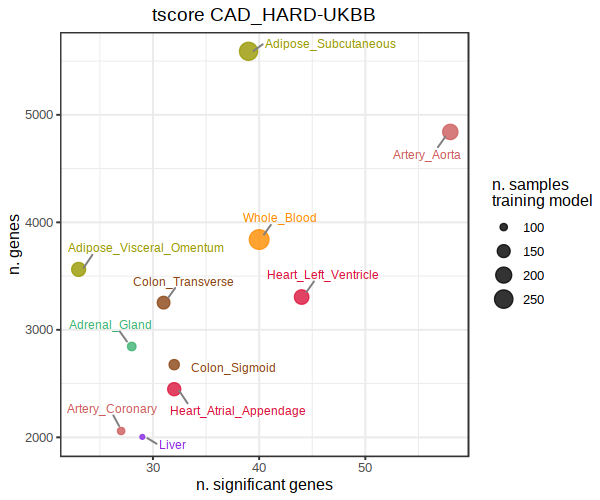

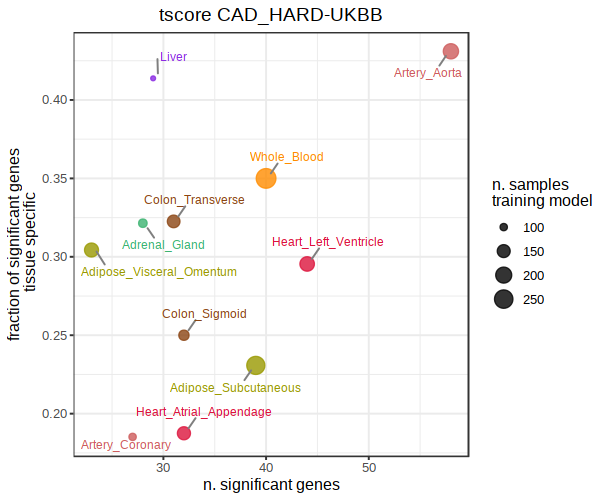

In [15]:
############################################################
### plot number of association per tissue vs specificity ###
############################################################
# Fig. S5A-B
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 100)

tscore_nsgin <- creat_dfnsign(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 10)
pathR_nsgin <- creat_dfnsign(tissues_name = tissues, res = pathR, id_pval_corr = 15, 
                             pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 15)
pathGO_nsgin <- creat_dfnsign(tissues_name = tissues, res = pathGO, id_pval_corr = 17, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 17)
tscore_red <- tscore
HLA_reg <- c(26000000, 34000000)
tscore_red <- tscore_red[!(tscore_red$chrom %in% 'chr6' & tscore_red$start_position <=HLA_reg[2] & tscore_red$start_position >= HLA_reg[1]) , ]
tscore_noMHC_nsgin <- creat_dfnsign(tissues_name = tissues, res = tscore_red, id_pval_corr = 10, pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 12)

print('tscore')
tscore_nsgin$table[length(tissues)+1,]
print('tscore not MHC')
tscore_noMHC_nsgin$table[length(tissues)+1,]
print('path-Reactome')
pathR_nsgin$table[length(tissues)+1,]
print('path-GO')
pathGO_nsgin$table[length(tissues)+1,]

# save
pl <- pl_number_function(df = tscore_nsgin$plot, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl$ngen
pl$frac




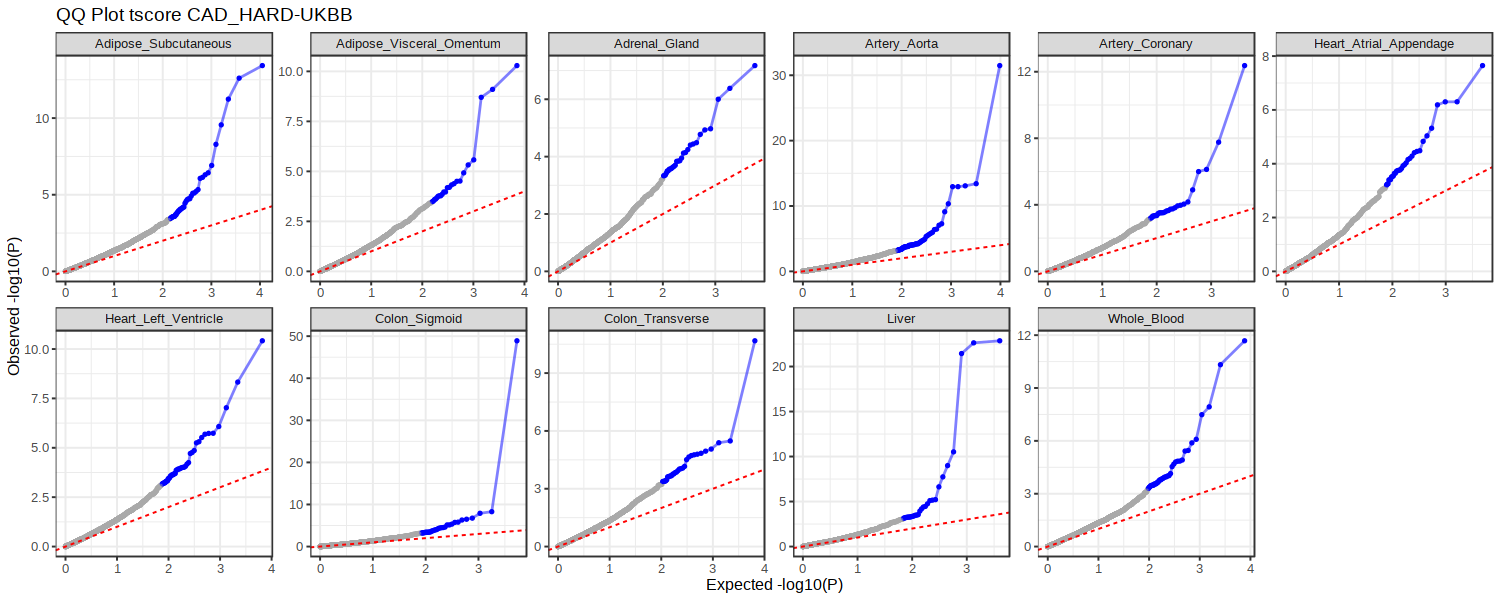

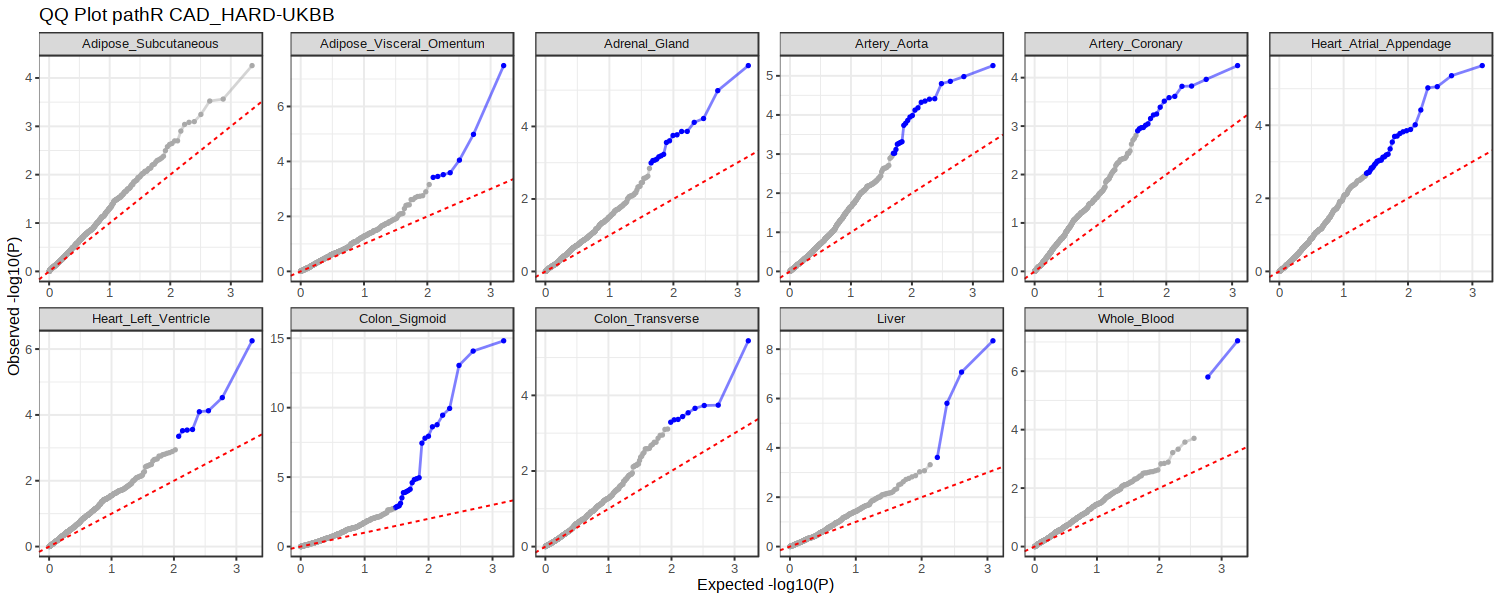

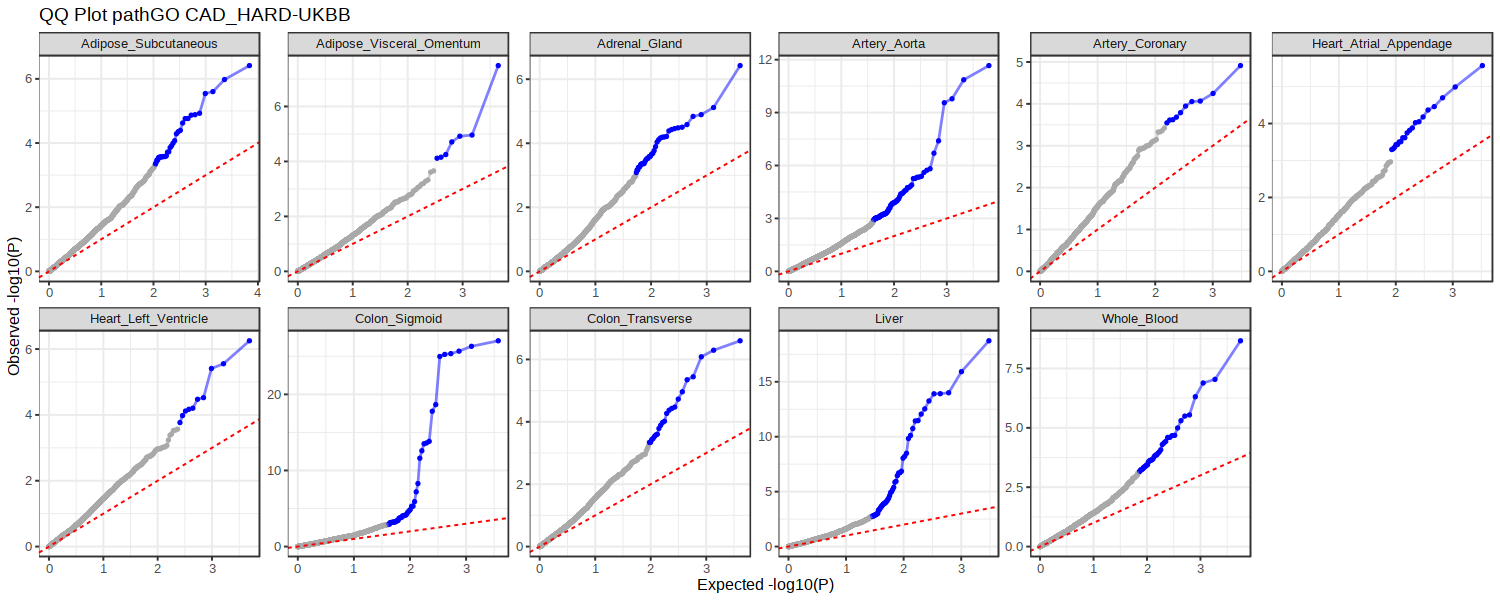

In [16]:
####################################
### plot qq-plot tissue specific ###
####################################
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 100)

# tscore
res <- qq_plot_tissues(data = tscore, color_tissues = color_tissues, id_pval = 8, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'tscore', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path Reactome
res <- qq_plot_tissues(data = pathR, color_tissues = color_tissues, id_pval = 13, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathR', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path GO
res <- qq_plot_tissues(data = pathGO, color_tissues = color_tissues, id_pval = 15, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathGO', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl



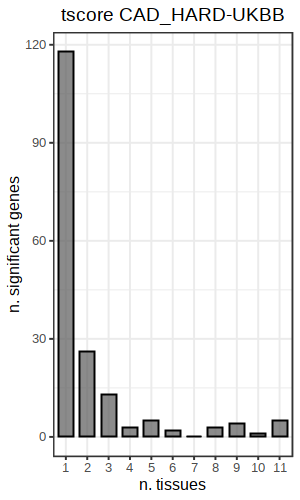

In [17]:
##################################################
### plot number of genes per number of tissues ###
##################################################
# Fig. 1B
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 100)

tscore_nsgin_tissue <- creat_dfnsign_tissueSpec(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                                                pval_FDR = pval_FDR)
# save
pl <- pl_numberSpec_function(df = tscore_nsgin_tissue, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl

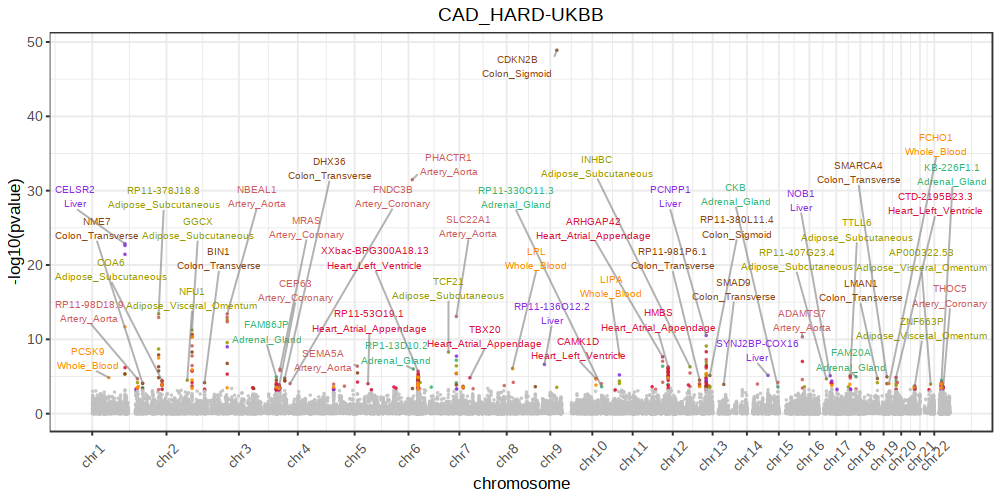

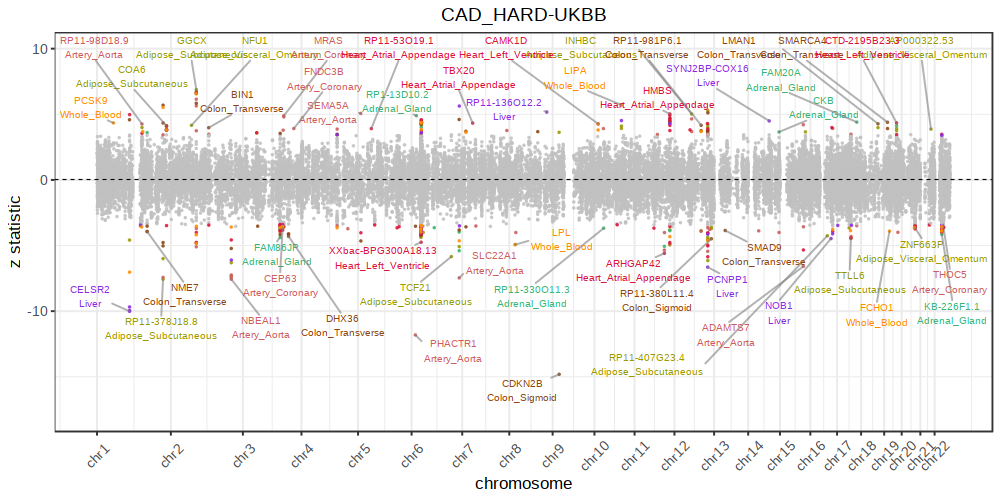

In [18]:
############################
### manhattan plot genes ###
############################
# Fig. 1A
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)

n_sign <- 20
# for each tissue keep name of the 20 most significant genes
tscore_df <- create_df_manhattan_plot(tissues_name = tissues, res = tscore, id_pval = 8, 
                                      pval_FDR = pval_FDR, df_color = color_tissues, id_name = 2, 
                                      n_sign = n_sign, gene = T)
# include only 1 gene per locus
new_list <- tscore_df$df[tscore_df$df$sign_name == 'yes', ]
dist_mat <- as.matrix(dist(new_list$id_pos, method = 'manhattan'))
keep_t <- new_list$name
# recursevly until no intersection
tmp <- new_list
while(any(dist_mat[upper.tri(dist_mat)] < 3)){
  
  t_list <- apply(dist_mat, 1, function(x) x < 3)
  len_t <- c()
  keep_t <- c()
  for(j in 1:nrow(t_list)){
    tmp_sel <-  new_list[new_list$name %in% tmp$name[t_list[j,]],]
    tmp_sel <- tmp_sel[!tmp_sel$name %in% len_t, ]
    len_t <- unique(c(len_t, tmp_sel$name))
    keep_t <- unique(c(keep_t, tmp_sel$name[which.max(tmp_sel$pval_tr)]))
  }
  
  tmp <- tmp[tmp$name %in% keep_t, ]
  dist_mat <- as.matrix(dist(tmp$id_pos,method = 'manhattan'))
  
}
tscore_df$df$sign_name[tscore_df$df$sign_name == 'yes' & !tscore_df$df$name %in% tmp$name] <- 'no'
tscore_df$df$name[tscore_df$df$sign_name == 'no'] <- ''

# save
pl_tot <- pl_manhattan_function(data_input = tscore_df, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)
# plot
pl_tot$manhattan_pl
pl_tot$zstat_pl
                  
                  
                  

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


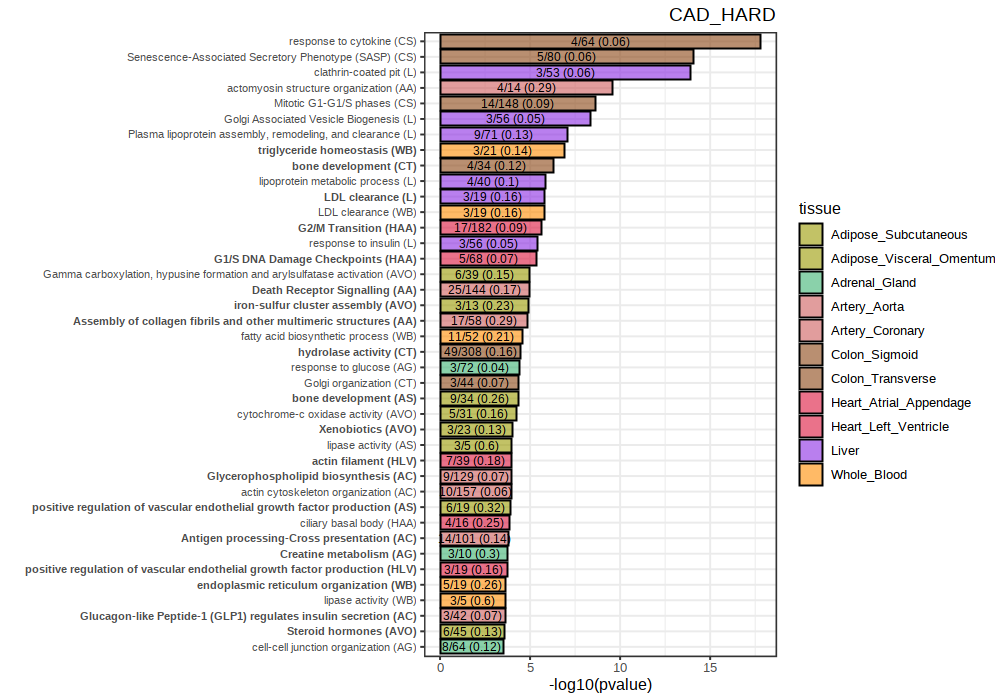

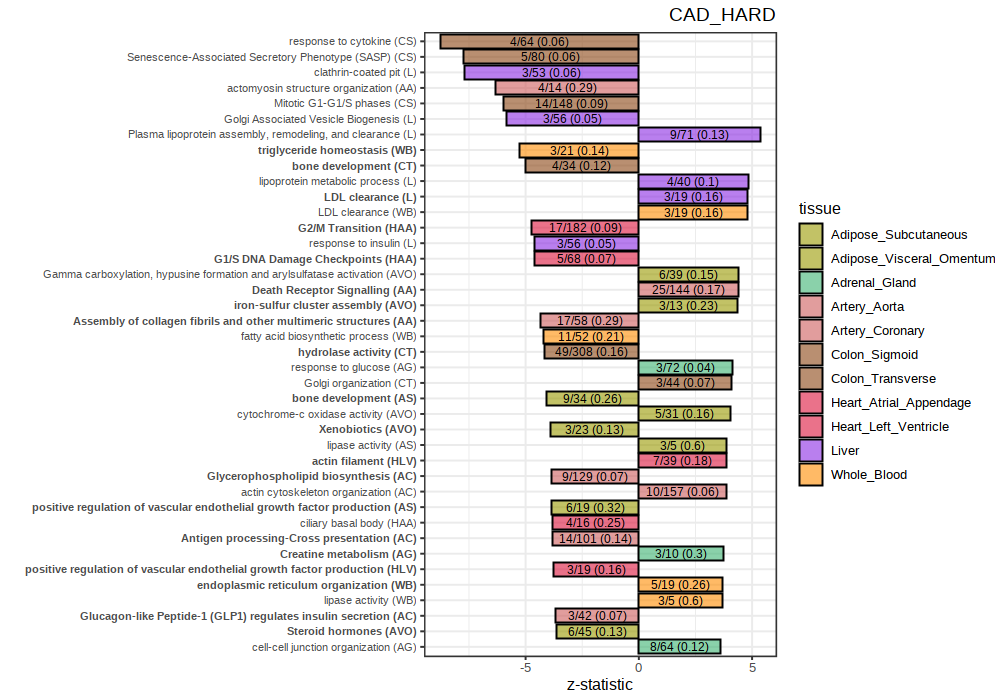

In [19]:
##############################################
### barplot selection significant pathways ###
##############################################
# Fig. 1D
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 100)

keep_path_file <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/keep_path_CAD_plot.csv'

pathR$type <- 'Reactome'
pathGO$type <- 'GO'
common_h <- intersect(colnames(pathR), colnames(pathGO))
tot_path <- rbind(pathR[, match(common_h, colnames(pathR))], pathGO[, match(common_h, colnames(pathGO))])

tmp_path <- read.csv(keep_path_file, h=T, stringsAsFactors = F)
tmp_path <- apply(tmp_path, 1, function(x) paste0(x, collapse = '_'))
tot_path_id <- apply(tot_path[, c('path', 'tissue', 'type')], 1, function(x) paste0(x, collapse = '_'))
best_path <- tot_path[match(tmp_path, tot_path_id), ]

best_path$logpval <-  -log10(best_path[, 13]) 
best_path$zstat <- best_path[, 12]
# save
pl <- plot_best_path(best_res = best_path, color_tissues = color_tissues, title_plot = pheno, type_mat = 'path', 
               outFold = out_fold, type_dat = type_dat, tissues = tissues, height_plot = 7, width_plot = 10, 
               id_pval = 13)
# plot
pl$pl_pval
pl$pl_zstat


[1] "Death Receptor Signalling"


Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


[1] "chr1"
[1] "chr2"
[1] "chr3"
[1] "chr5"
[1] "chr6"
[1] "chr7"
[1] "chr8"
[1] "chr9"
[1] "chr10"
[1] "chr11"
[1] "chr13"
[1] "chr14"
[1] "chr15"
[1] "chr19"
[1] "chr20"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 7 rows containing missing values (geom_point).”


[1] "Cardiac conduction"


Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


[1] "chr1"
[1] "chr2"
[1] "chr6"
[1] "chr7"
[1] "chr11"
[1] "chr13"
[1] "chr19"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 7 rows containing missing values (geom_point).”


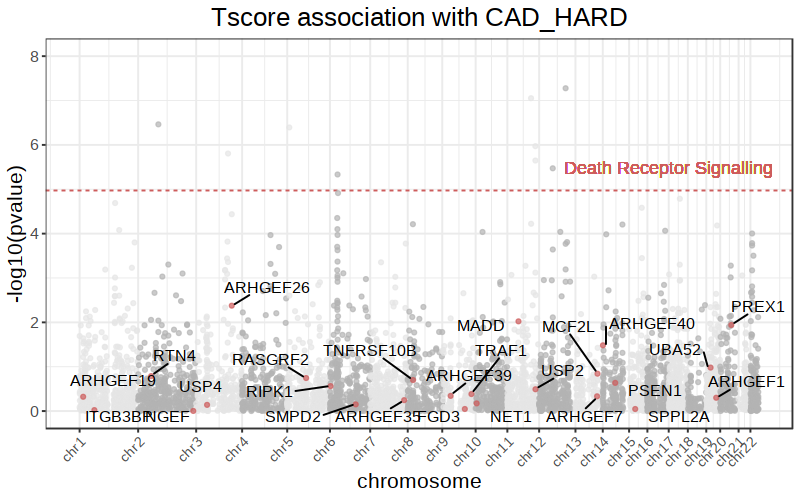

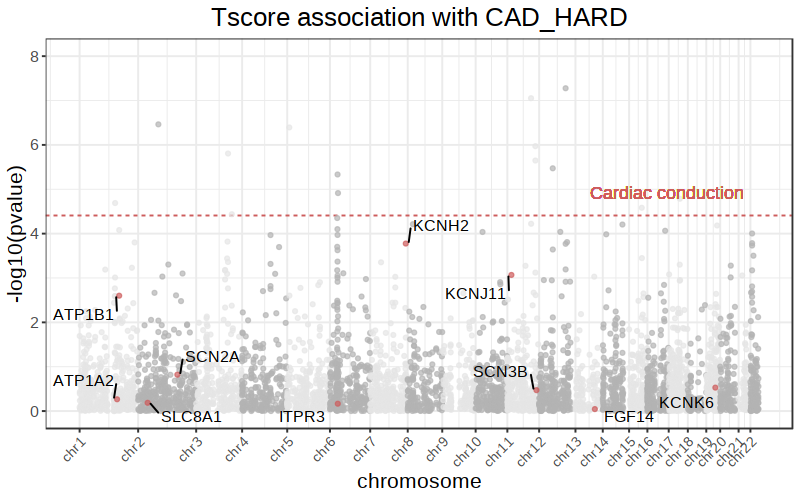

In [20]:
###################################
### showcase pathway enrichment ###
###################################
# Fig. 1F, S5C
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

train_fold_original <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/'
tissue <- 'Artery_Aorta'
pathways <- c('Death Receptor Signalling', 'Cardiac conduction')
fold_tissue <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/Artery_Aorta/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/'
fold_geno_input <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'
id_pval <- 1

for(pathway in pathways){
    
    print(pathway)
    color_tmp <- color_tissues$color[color_tissues$tissues == tissue]
    info_res <- get(load(sprintf('%spval_CAD_pheno_covCorr.RData', fold_tissue[1])))
    id <- which(info_res$pathScore_reactome[[id_pval]]$path == pathway)
    genes_path <- info_res$info_pathScore_reactome[[id_pval]][[id]]
    gene_res <- info_res$tscore[[id_pval]]
    gene_info <- fread(sprintf('%sresPrior_regEval_allchr.txt', train_fold[grepl(tissue, train_fold)]), h=T,stringsAsFactors = F, data.table = F)
    resBeta <- get(load(sprintf('%sresPrior_regCoeffSnps_allchr.RData',  train_fold[grepl(tissue, train_fold)])))
    train_fold_tissue <- train_fold[grepl(tissue, train_fold)]
    
    # save
    pl <- plot_showcase(gene_res = gene_res, gene_info = gene_info, genes_path = genes_path, 
                  tissue = tissue, pathway = pathway, color_tmp = color_tmp, id_pval_path = 13, 
                  pheno = pheno, fold = out_fold, resBeta = resBeta, train_fold_tissue = train_fold_tissue, 
                  fold_geno_input_tmp = fold_geno_input, 
                  train_fold_original_tmp = train_fold_original, name_gwas_pval = 'CAD_p_dgc')
    # warnings refer to most significant associations (in general) that are removed if not used in the pathway for display reasons
    # plot
    print(pl$pl_manh)    
}

  

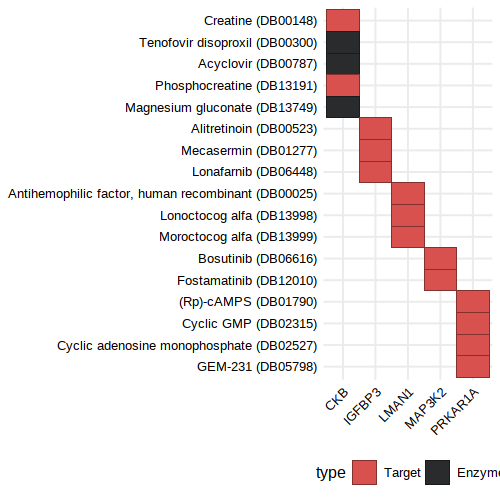

In [121]:
######################################
### annotate genes by drug targets ###
######################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
library(drugbankR)
drugbank_genes <- 'refData/drugBank/All_geneTargets_enzymes.txt'
df <- queryDB(type = "getAll", db_path=sprintf("%sdrugbank_5.1.7.db", 'refData/drugBank/'))
id_CAD = unique(c(grep("artery", df$`mechanism-of-action`), grep("artery", df$indication)))
name_CAD <- unique(df[id_CAD, "drugbank-id"])

genes_sign <- unique(tscore_complete$external_gene_name)
genes_new <- unique(tscore_complete$external_gene_name[!tscore_complete$best_GWAS_signBH])
db_genes <- fread(drugbank_genes, h=T, stringsAsFactors = F, data.table = F)

db_genes_sign <- db_genes[db_genes$gene %in% genes_new,]
db_genes_sign <- db_genes_sign[order(db_genes_sign$gene), ]

# create 0-1 matrix drugs x targets
db_drug_name <- db_genes_sign[!duplicated(db_genes_sign$id), 1:2]
drug_gene_mat <- matrix(0,nrow = nrow(db_drug_name), ncol = length(unique(db_genes_sign$gene)))
rownames(drug_gene_mat) <- paste0(db_drug_name$drug, ' (', db_drug_name$id, ')')
colnames(drug_gene_mat) <- unique(db_genes_sign$gene)
for(i in 1:nrow(db_drug_name)){
    id <- colnames(drug_gene_mat) %in% db_genes_sign$gene[db_genes_sign$id == db_drug_name$id[i]]
    gene_type <- sapply(which(id), function(x) db_genes_sign$class[db_genes_sign$id == db_drug_name$id[i] & db_genes_sign$gene == colnames(drug_gene_mat)[x]])
    drug_gene_mat[i, id] <- gene_type
}
#drug_gene_mat
                        
# plot 
db_genes_sign$new_name <- paste0(db_genes_sign$drug, ' (', db_genes_sign$id, ')') 
db_genes_sign$new_name <- factor(db_genes_sign$new_name, levels = rev(unique(db_genes_sign$new_name)))
db_genes_sign$type <- NA
db_genes_sign$type[db_genes_sign$class == 'E'] <- 'Enzyme'
db_genes_sign$type[db_genes_sign$class == 'TR'] <- 'Transporters'           
db_genes_sign$type[db_genes_sign$class == 'T'] <- 'Target'
db_genes_sign$type <- factor(db_genes_sign$type, levels = c('Target', 'Transporters', 'Enzyme'))

pl <- ggplot(db_genes_sign, aes(gene, new_name)) + 
            geom_tile(aes(fill = type), colour = "black") + 
            theme_minimal()+
            theme(axis.title = element_blank(), axis.text = element_text(color = 'black'), 
                 axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'bottom')+
            scale_fill_manual(values=c("#D9514EFF", "#2A2B2DFF", "#2DA8D8FF"))
pl
# save
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.png', out_fold, pheno), plot = pl, width = 5, height = 5, dpi = 500)
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.pdf', out_fold, pheno), plot = pl, width = 5, height = 5, compress = F)
  

In [120]:
#########################################
### annotate pathways by drug targets ###
#########################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
path_ann_drug <- path_complete_ann[, c('path', 'ngenes_tscore', 'CAD_HARD_z_t', 'CAD_HARD_pval', 'CAD_HARD_BHcorr', 'genes_path', 'tissue', 'replicated','class_pathway', 'type_path')]
path_ann_drug$drugBank_ann <- NA
path_ann_drug$drugBank_n <- NA
path_ann_drug$drugBank_id <- NA
path_ann_drug$drugBank_gene <- NA
path_ann_drug$drugBank_usedForCAD <- NA

for(i in 1:nrow(path_ann_drug)){
    path_name = path_ann_drug$path[i]
    genes_path <- strsplit(path_ann_drug$genes_path[path_ann_drug$path == path_name], split = ',')[[1]]
    drug_ann <- db_genes[db_genes$gene %in% genes_path,,drop = F]
    path_ann_drug$drugBank_ann[i] <- paste0(unique(drug_ann$drug), collapse = '-and-')
    path_ann_drug$drugBank_id[i] <- paste0(unique(drug_ann$id), collapse = '-and-')
    path_ann_drug$drugBank_n[i] <- nrow(drug_ann)
    path_ann_drug$drugBank_gene[i] <- paste0(unique(drug_ann$gene), collapse = '-and-')
    path_ann_drug$drugBank_usedForCAD[i] <- paste0(unique(drug_ann$drug[drug_ann$id %in% name_CAD]), collapse = '-and-')
}
# save table
write.table(path_ann_drug, file = sprintf('%sPathScore_CADHARD_annotated_drugBank.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

# reduce category
path_ann_drug_red <- path_ann_drug[path_ann_drug$type_path %in% c('Reactome', 'GO') & path_ann_drug$class_pathway == "pathway P < genes P & genes FDR > 0.05", ]
path_ann_drug_red <- path_ann_drug_red[(path_ann_drug_red$path %in% pathGO$path[pathGO$path_ont %in% c('BP', 'MF')] & path_ann_drug_red$type_path %in% 'GO') | path_ann_drug_red$type_path %in% 'Reactome',]
# save table
write.table(path_ann_drug_red, file = sprintf('%sPathScore_CADHARD_annotated_drugBank_notSignGenes_GOandReactome.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)
